# Small induction motor example

Illustrating basic functionality on a small induction motor example. The model equations are taken from the paper

Aguilera, F., et al. "_Current-sensor fault detection and isolation for induction-motor drives using a geometric approach._", Control Engineering Practice 53 (2016): 35-46.

In [1]:
import matplotlib.pyplot as plt
import faultdiagnosistoolbox as fdt
import sympy as sym

## Modelling

First, define the model using the ``sympy`` symbolic toolbox in Python.

In [2]:
model_def = {'type': 'Symbolic',
             'x': ['i_a', 'i_b', 'lambda_a', 'lambda_b', 'w',
                   'di_a', 'di_b', 'dlambda_a', 'dlambda_b', 'dw', 'q_a', 'q_b', 'Tl'],
             'f': ['f_a', 'f_b'], 'z': ['u_a', 'u_b', 'y1', 'y2', 'y3'],
             'parameters': ['a', 'b', 'c', 'd', 'L_M', 'k', 'c_f', 'c_t']}

i_a, i_b, lambda_a, lambda_b, w, di_a, di_b, dlambda_a, dlambda_b, dw, q_a, q_b, Tl = sym.symbols(model_def['x'])
f_a, f_b = sym.symbols(model_def['f'])
u_a, u_b, y1, y2, y3 = sym.symbols(model_def['z'])
a, b, c, d, L_M, k, c_f, c_t = sym.symbols(model_def['parameters'])

model_def['rels'] = [
  -q_a + w*lambda_a,
  -q_b + w*lambda_b, 
  -di_a + -a*i_a + b*c*lambda_a + b*q_b + d*u_a,
  -di_b + -a*i_b + b*c*lambda_b + b*q_a + d*u_b,
  -dlambda_a + L_M*c*i_a - c*lambda_a-q_b, 
  -dlambda_b + L_M*c*i_b - c*lambda_b-q_a, 
  -dw + -k*c_f*w + k*c_t*(i_a*lambda_b - i_b*lambda_a) - k*Tl,
  fdt.DiffConstraint('di_a','i_a'),
  fdt.DiffConstraint('di_b','i_b'),
  fdt.DiffConstraint('dlambda_a','lambda_a'),
  fdt.DiffConstraint('dlambda_b','lambda_b'),
  fdt.DiffConstraint('dw','w'),
  -y1 + i_a + f_a,
  -y2 + i_b + f_b,
  -y3 + w]

model = fdt.DiagnosisModel(model_def, name ='Induction motor')


Basic model information can be displayed using the `Lint` class method.

In [3]:
model.Lint()

Model: Induction motor

  Type:Symbolic, dynamic

  Variables and equations
    13 unknown variables
    5 known variables
    2 fault variables
    15 equations, including 5 differential constraints

  Degree of redundancy: 2
  Degree of redundancy of MTES set: 1


  Model validation finished with 0 errors and 0 warnings.


To plot the structural model, use the `PlotModel` class method

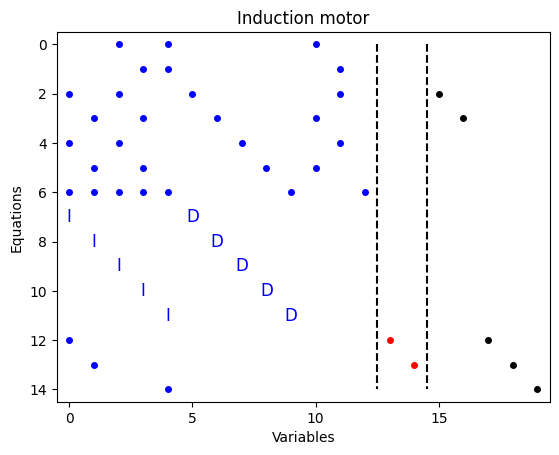

In [4]:
_, ax = plt.subplots(num=10)
model.PlotModel(ax=ax)

## Basic Analysis
A basic tool in structural analysis is the Dulmage-Mendelsohn decomposition. You can perform the decomposition directly using the function `fdt.dmperm.GetDMParts` och using the class method `GetDMParts`

In [5]:
dm = fdt.dmperm.GetDMParts(model.X)
print(dm)
dm = model.GetDMParts()
print(dm)

DMResult(Mm=EqBlock(row=[], col=[]), M0=[EqBlock(row=array([6], dtype=int64), col=array([12], dtype=int64)), EqBlock(row=array([11], dtype=int64), col=array([9], dtype=int64))], Mp=EqBlock(row=array([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 12, 13, 14], dtype=int64), col=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11], dtype=int64)), rowp=array([ 6, 11,  2,  3,  9, 10, 14,  7,  8,  4,  5,  0,  1, 12, 13],
      dtype=int64), colp=array([12,  9,  0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11], dtype=int64), M0eqs=array([ 6, 11], dtype=int64), M0vars=array([12,  9], dtype=int64))
DMResult(Mm=EqBlock(row=[], col=[]), M0=[EqBlock(row=array([6], dtype=int64), col=array([12], dtype=int64)), EqBlock(row=array([11], dtype=int64), col=array([9], dtype=int64))], Mp=EqBlock(row=array([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 12, 13, 14], dtype=int64), col=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11], dtype=int64)), rowp=array([ 6, 11,  2,  3,  9, 10, 14,  7,  8,  4,  5,  0,  1, 12, 13],
      

You can also visualize the decomposition using the `PlotDM` class method. It is also possible to do an extended Dulmage-Mendelsohn where equations are grouped in equivalence classes, see paper 

Krysander, M., Åslund, J., & Nyberg, M. (2007). "_An efficient algorithm for finding minimal overconstrained subsystems for model-based diagnosis_". IEEE Transactions on Systems, Man, and Cybernetics-Part A: Systems and Humans, 38(1), 197-206.

for more details.

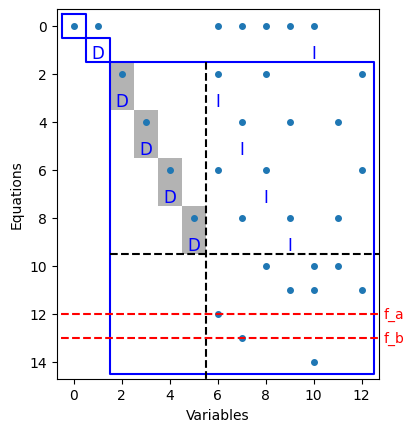

In [6]:
_, ax = plt.subplots(num=23)
model.PlotDM(fault=True, eqclass=True, ax=ax)

## Isolability Analysis

Isolability properties of the model can be computed using the `IsolabilityAnalysis` method.

Text(0.5, 1.0, 'Mixed causality')

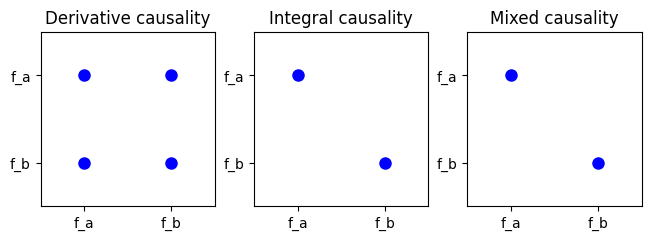

In [7]:
_, ax = plt.subplots(1, 3, num=20, layout="constrained")
model.IsolabilityAnalysis(ax=ax[0], causality='der')
model.IsolabilityAnalysis(ax=ax[1], causality='int')
model.IsolabilityAnalysis(ax=ax[2])

ax[0].set_title('Derivative causality')
ax[1].set_title('Integral causality')
ax[2].set_title('Mixed causality')

## Redundant sets of equations

MSO and MTES sets of equations are very useful when designing residual generators. These can be directly computed using the `MSO` and `MTES` class methods as

In [8]:
# Find set of MSOS and MTES
msos = model.MSO()
mtes = model.MTES()
print(f"Found {len(msos)} MSO sets and {len(mtes)} MTES sets.")

Found 9 MSO sets and 2 MTES sets.


Low differential-index and observability can be directly analyzed for the MSO sets

In [9]:
oi_mso = [model.IsObservable(m_i) for m_i in msos]
li_mso = [model.IsLowIndex(m_i) for m_i in msos]
print(f'Out of {len(msos)} MSO sets, {sum(oi_mso)} observable, {sum(li_mso)} low (structural) differential index')

Out of 9 MSO sets, 9 observable, 4 low (structural) differential index


and also for the MTES sets

In [10]:
oi_mtes = [model.IsObservable(m_i) for m_i in mtes]
li_mtes = [model.IsLowIndex(m_i) for m_i in mtes]
print(f'Out of {len(mtes)} MTES sets, {sum(oi_mtes)} observable, {sum(li_mtes)} low (structural) differential index')

Out of 2 MTES sets, 2 observable, 2 low (structural) differential index


## Isolability analysis for the MSO and MTES sets of equations

The isolability performance of hte full sets of MSO/MTES should be the same as the isolability performance of the model. This can be verified as below

Text(0.5, 1.0, 'Fault Signature Matrix (MSO sets)')

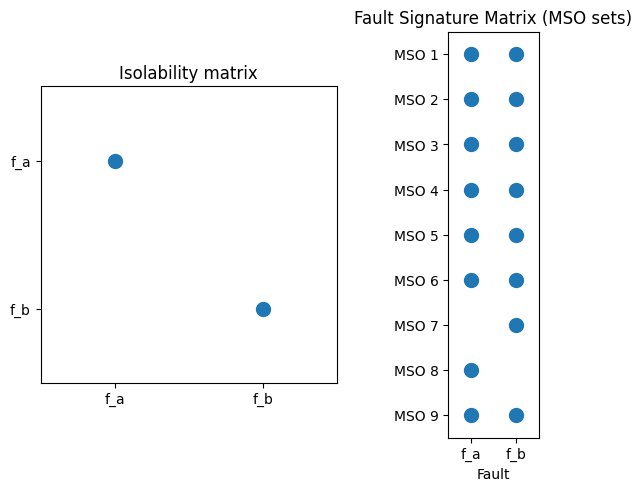

In [11]:
FSM = model.FSM(msos)
fig, ax = plt.subplots(1, 2, num=30, clear=True, layout="constrained")
_ = model.IsolabilityAnalysisArrs(msos, ax=ax[0])
ax[0].set_title('Isolability matrix')

ax[1].spy(FSM, markersize=10, marker='o')
ax[1].xaxis.tick_bottom()
ax[1].set_xticks(range(model.nf()))
ax[1].set_xticklabels(model.f)
ax[1].set_yticks(range(len(msos)))
ax[1].set_yticklabels([f"MSO {i + 1}" for i in range(len(msos))])
ax[1].set_xlabel('Fault')
ax[1].set_title('Fault Signature Matrix (MSO sets)')

Text(0.5, 1.0, 'Fault Signature Matrix (MTES sets)')

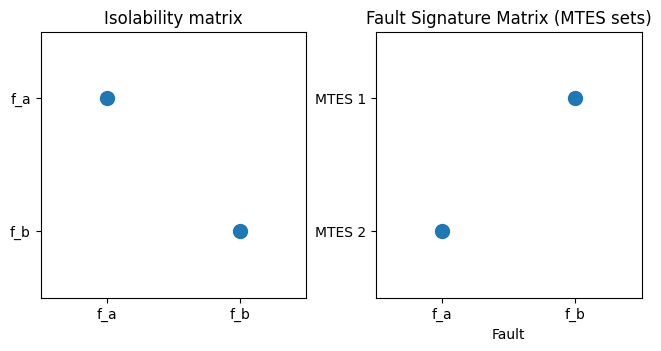

In [12]:
FSM = model.FSM(mtes)
fig, ax = plt.subplots(1, 2, num=31, clear=True, layout="constrained")
_ = model.IsolabilityAnalysisArrs(mtes, ax=ax[0])
ax[0].set_title('Isolability matrix')

ax[1].spy(FSM, markersize=10, marker='o')
ax[1].xaxis.tick_bottom()
ax[1].set_xticks(range(model.nf()))
ax[1].set_xticklabels(model.f)
ax[1].set_yticks(range(len(mtes)))
ax[1].set_yticklabels([f"MTES {i + 1}" for i in range(len(mtes))])
ax[1].set_xlabel('Fault')
ax[1].set_title('Fault Signature Matrix (MTES sets)')


## Generate code for residual generator
Code for a residual generator, based on an MSO/MTES, can be generated. Note that this part of the toolbox is experimental and could fail at any moment.

The basic principle in sequential residual generation is to use a single equation as redundant/residual equation and use the remaining equations in the MSO/MTES to compute all unknown variables. This is done by performing a matching and then symbolically compute the analytical expressions. See below for an example.

But first, we need to determine which equation to use as a residual equation. For this, the `MSOCausalitySweep` is a usefuyl class method.

In [13]:
print(model.MSOCausalitySweep(mtes[0]))


['mixed', 'mixed', 'mixed', 'mixed', 'mixed', 'mixed', 'mixed', 'int', 'mixed', 'mixed', 'int', 'mixed']


This indicates that equations 8 and 11 results in integral causality residual generators and all other requires numerical differentiation. Let's choose equation 11 (index 10) as redundant equation and generate the code.

In [14]:
red_eq = mtes[0][10] 
model.syme[red_eq]
M0 = [e for e in mtes[0] if e != red_eq]

Gamma = model.Matching(M0)
model.SeqResGen(Gamma, red_eq, 'ResGen', batch=True, language='C')

Generating residual generator ResGen (C, batch)
  Generating code for the exactly determined part: ..
  Generating code for the residual equations
  Writing residual generator file
Files ResGen.cc and ResGen_setup.py generated
Compile by running: python ResGen_setup.py build_ext --inplace


It is also possible to generate Python code

In [15]:
model.SeqResGen(Gamma, red_eq, 'ResGen', batch=True, language='Python')

Generating residual generator ResGen (Python, batch)
  Generating code for the exactly determined part: ..
  Generating code for the residual equations
  Writing residual generator file
File ResGen.py generated.
